<a href="https://colab.research.google.com/github/Affu321/11individu/blob/master/UAS_AI_FRUITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Fruit Recognition**

#### CNN for detecting images of 33 different fruits and vegetables, written in PyTorch.

Tools:
- Kaggle API
- Colab Shell
- PyTorch (torchvision, Dataset, nn)
- Image Displaying via matplotlib and skimage
- Google Colab (GPU usage, notebook forms, saving models to drive)

Sections:


1.   Data Analysis
2.   Dataset
3.   CNN Model
4.   Training
5.   Results
6.   Testing on New Data
7.   Conclusion




# **Section 1**
## Data Analysis

In [1]:
#@title Load Kaggle API (Enter kaggle API key) { display-mode: "form" }
!pip install -q kaggle

from google.colab import files

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#@title Download Fruits Dataset { vertical-output: false }
!kaggle datasets download sshikamaru/fruit-recognition
!unzip fruit-recognition.zip -d fruit-dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: fruit-dataset/train/train/Pep

In [3]:
#total test files
!ls -1 fruit-dataset/test/test | wc -l

#total fruit types
!ls -1 fruit-dataset/train/train | wc -l

#total train files
!ls -lR fruit-dataset/train/train | grep "^-" | wc -l

5641
33
16854


In [4]:
!ls fruit-dataset/train/train

'Apple Braeburn'      'Cactus fruit'   'Grape Blue'    Orange	       'Pepper Red'   Strawberry
'Apple Granny Smith'   Cantaloupe       Kiwi	       Papaya	        Pineapple     Tomato
 Apricot	       Cherry	        Lemon	      'Passion Fruit'   Plum	      Watermelon
 Avocado	       Clementine       Limes	       Peach	        Pomegranate
 Banana		       Corn	        Mango	       Pear	       'Potato Red'
 Blueberry	      'Cucumber Ripe'  'Onion White'  'Pepper Green'    Raspberry


In [5]:
#@title Combine Dataset to Single Folder
sh = """
#!/bin/bash

# change to the parent directory
cd fruit-dataset/train/train

for d in */ ; do for f in "$d"/* ; do mv "$f" . ; done ; done
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

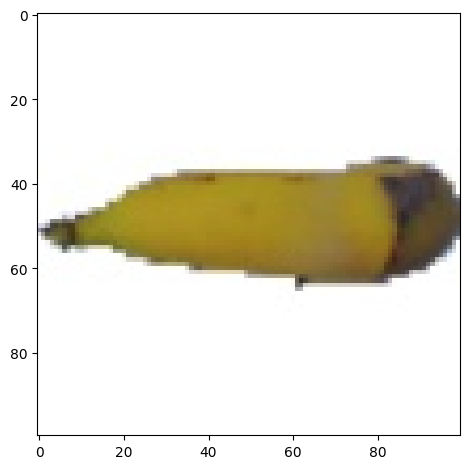

In [8]:
#test data access

import numpy as np
from skimage import io

def get_train_fruit(name, num=1):
  return io.imread(f"fruit-dataset/train/train/{name}_{num}.jpg")

def get_test_fruit(num=1):
  return io.imread(f"fruit-dataset/test/test/{str(num).zfill(4)}.jpg")

im_cv = get_train_fruit("Banana",2)

io.imshow(im_cv)

In [9]:
#@title Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import datetime
import pandas as pd
import seaborn as sns
import subprocess
import os
import re

# **Section 2**
## Dataset

In [10]:
#Process Dataset

class FruitsDataset(Dataset):
  def __init__(self, file_path, transforms=None):
    self.file_path = file_path
    self.transforms = transforms

    contents = os.listdir(self.file_path)

    #filter jpgs
    def jpg_filter(string, eq=True):
      if len(string) < 5:
        return False or not eq

      if eq:
        return string[-4:] == ".jpg"
      else:
        return string[-4:] != ".jpg"

    #get all images
    self.files = list(filter(jpg_filter, contents))

    #get all labels
    self.label_names = sorted(list(filter(lambda x: jpg_filter(x, False), contents)))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    img = io.imread(f"{self.file_path}/{self.files[index]}")

    #extract fruit name: fruit_num.jpg
    label = self.files[index].split("_")[0]
    label = torch.tensor(self.label_names.index(label))

    if self.transforms:
      img = self.transforms(img)


    return (img, label)

In [11]:
fruits_dataset = FruitsDataset("fruit-dataset/train/train", transforms=
                                                transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Resize((64, 64)),
                                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                ]))

In [12]:
split = int(len(fruits_dataset)*.8)
fruits_train, fruits_test = torch.utils.data.random_split(fruits_dataset, [split, len(fruits_dataset)-split])

In [13]:
len(fruits_train), len(fruits_test)

(13483, 3371)

In [14]:
#image size
print(fruits_train[0][0].shape)

#image label
print(f"{fruits_train[0][1]} => {fruits_dataset.label_names[fruits_train[0][1]]}")

#total labels & label names
print(f"{len(fruits_dataset.label_names)}, label names={fruits_dataset.label_names}")

torch.Size([3, 64, 64])
19 => Papaya
33, label names=['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


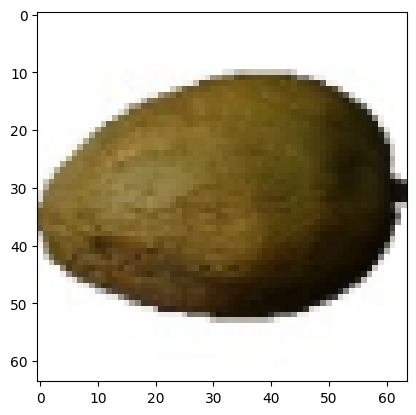

In [15]:
#@title Display image from training set
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(fruits_train[0][0])

# **Section 3**
## CNN Model

In [16]:
#Fruit Model
import torch.nn.functional as F

#[3C x 64 x 64] -> conv2d[32 x 64 x 64] -> relu -> maxpool2d[32 x 32 x 32] -> conv2d[8 x 32 x 32] -> relu -> maxpool2d[8 x 16 x 16]
#flatten[8*16*16] -> lin[128] -> relu -> lin[84] -> relu -> lin[33]

#input is 3C x 64 x 64
#output is 33, based on total img labels

class FruitNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8*16*16, 128)
    self.fc2 = nn.Linear(128, 84)
    self.fc3 = nn.Linear(84, 33)

  def forward(self, x):
    out = self.conv1(x)
    out = F.max_pool2d(torch.relu(out), 2)

    out = self.conv2(out)
    out = F.max_pool2d(torch.relu(out), 2)

    out = out.view(-1, 8 * 16 * 16)
    out = torch.relu(self.fc1(out))
    out = torch.relu(self.fc2(out))
    out = self.fc3(out)

    return out

In [17]:
model = FruitNet()

model

FruitNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
)

In [18]:
#test image passing
model(fruits_train[0][0])

tensor([[-0.0303,  0.0119,  0.1027, -0.1095, -0.0011,  0.0729, -0.0351, -0.0095,
          0.0075,  0.0873, -0.0496,  0.0031, -0.0597,  0.0712,  0.0515,  0.0550,
         -0.1074, -0.0386, -0.0945,  0.0804, -0.0707,  0.0781,  0.0391, -0.0478,
          0.0515, -0.0551, -0.1337, -0.0447,  0.1037,  0.1325,  0.0410, -0.0456,
         -0.0677]], grad_fn=<AddmmBackward0>)

# **Section 4**
## Training

In [19]:
#@title Change Runtime to GPU (must enable via runtime tab)

#change runtime type to GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [20]:
#@title Define Training Loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device) #send to current device
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [22]:
#@title Run model
train_loader = torch.utils.data.DataLoader(fruits_train, batch_size=64,shuffle=True)

learning_rate = 1e-2 #@param {type:"number"}
epochs = 20 #@param {type:"number"}



model = FruitNet().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #
loss_fn = nn.CrossEntropyLoss() #
training_loop(
  n_epochs = epochs,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

2024-01-04 17:42:36.615418 Epoch 1, Training loss 0.961130305983444
2024-01-04 17:45:14.953363 Epoch 10, Training loss 0.052436352365303196
2024-01-04 17:48:15.813663 Epoch 20, Training loss 0.03828385015860694


# **Section 5**
## Results

In [23]:
#@title Test Accuracy of Train/Validation set
train_loader = torch.utils.data.DataLoader(fruits_train, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(fruits_test, batch_size=64,shuffle=False)
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device) #send to current device
        labels = labels.to(device=device) #
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.98


In [27]:
#@title Save model to Google Drive
#connect to colab book
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#@title Save Model to filepath
data_path = "drive/MyDrive/PyTorch/models/" #@param ['drive/MyDrive/PyTorch/models/'] {allow-input: true}
#save model to filepath
torch.save(model.state_dict(), data_path + 'fruits.pt')

In [29]:
loaded_model = FruitNet().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'fruits.pt', map_location=device))

<All keys matched successfully>

In [30]:
#validate again to make sure model saved correctly
validate(loaded_model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.98


# **Section 6**
## Testing on New Data

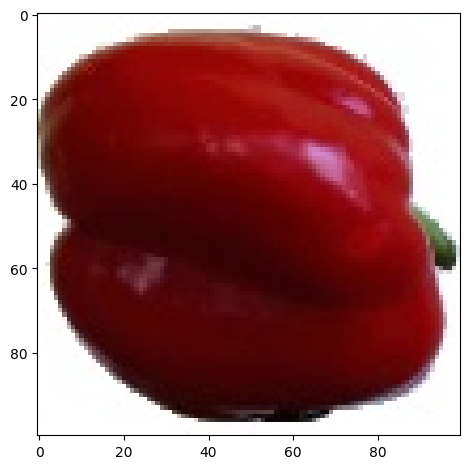

In [32]:
#@title Display Test Image
test_index =  5454#@param {type:"integer"}

img = get_test_fruit(test_index)

io.imshow(img)

In [33]:
#@title Transform Test Image

#transform test image
transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((64, 64)),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_img = transformations(img)

In [34]:
#@title Predict Fruit!
#do prediction
outputs = model(test_img.to(device=device))
_, predicted = torch.max(outputs, dim=1)

fruits_dataset.label_names[predicted.item()]

'Pepper Red'

# **Section 7**
## Conclusion

The model is able to succesfully label fruits with high accuracy ~.95, although the validation set has high accuracy, there might be a possibility of overfitting due to the drastic drop in loss between Epoch 1 and 10. However, it is still able to predict completely new data (section 6) well, so it is likely not significant.

Considering the dataset only includes images of fruit in a white background, it will be necessary to preprocess input to get rid of any background that could possibly reduce its ability to predict. Alternatively, this can be solved by adding noise, or variety to the layout of the images.

Another note is that most of the fruits are at one stage of growth, as seen in the images of mangos, they are almost all green, including different ages of fruit can help improve the accuracy of new data tested.